In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.5f' % x)

df_ = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df_.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom


In [372]:
df = df_.copy()
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C",na=False)]
df = df[df["Quantity"]>0]
df = df[df["Price"]>0]

In [373]:
plt.style.use("dark_background")
def plot_boxplot_and_hist(data, variable):
    
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)})
    
   
    axs[0].boxplot(data[variable], vert=False)
    axs[0].set_title(variable)
    
    
    axs[1].hist(data[variable], color="orange", edgecolor="black",bins=30)
    
    plt.show()

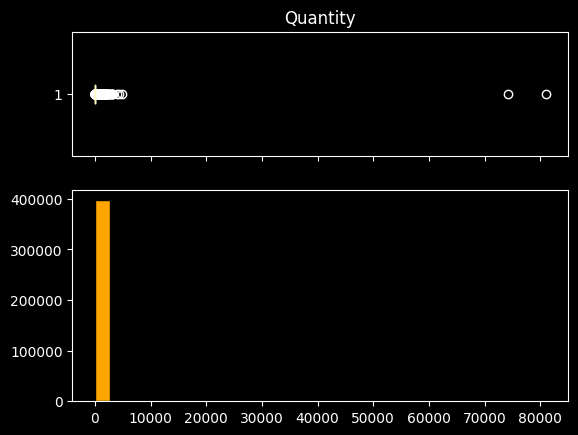

In [374]:
plot_boxplot_and_hist(df,"Quantity")

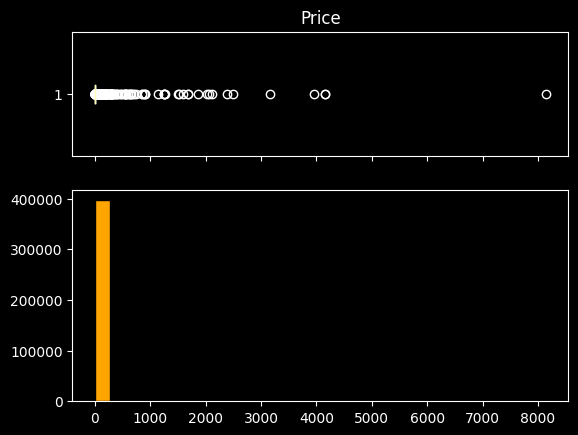

In [375]:
plot_boxplot_and_hist(df,"Price")

In [376]:
def find_limits(df,variable):
    q1 = df[variable].quantile(0.01)
    q3 = df[variable].quantile(0.99)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr
    df[variable].clip(upper=upper_limit,inplace=True)
    
find_limits(df,"Quantity")
find_limits(df,"Price")
df["total_price"] = df["Quantity"] * df["Price"]

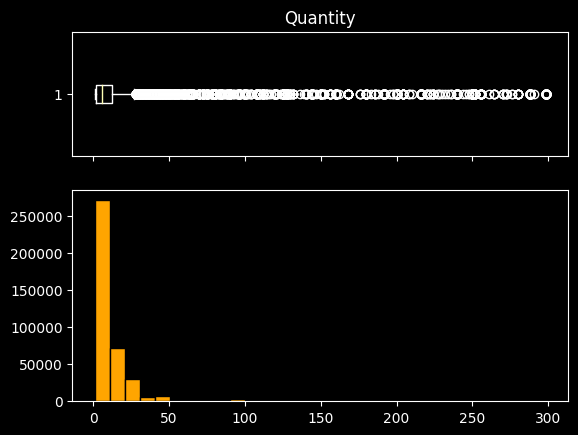

In [377]:
plot_boxplot_and_hist(df,"Quantity")

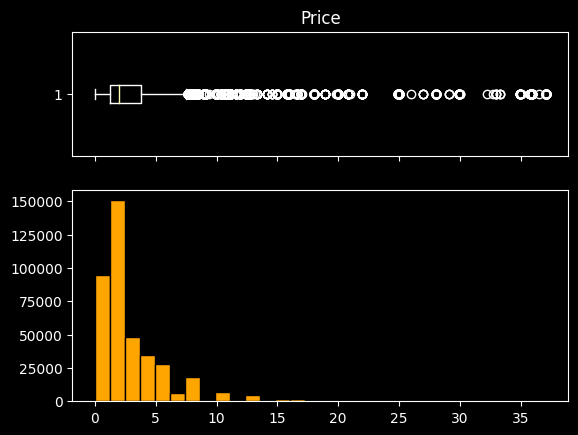

In [378]:
plot_boxplot_and_hist(df,"Price")

In [379]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,total_price
count,397885.00000,397885,397885.00000,397885.00000,397885.00000
mean,11.83077,2011-07-10 23:41:56.419316992,2.89349,15294.41688,20.62982
min,1.00000,2010-12-01 08:26:00,0.00100,12346.00000,0.00100
25%,2.00000,2011-04-07 11:12:00,1.25000,13969.00000,4.68000
50%,6.00000,2011-07-31 14:39:00,1.95000,15159.00000,11.80000
75%,12.00000,2011-10-20 14:33:00,3.75000,16795.00000,19.80000
max,298.50000,2011-12-09 12:50:00,37.06000,18287.00000,3268.57500
std,25.52305,NaN,3.22718,1713.14442,51.82853


In [380]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [381]:
today_date= dt.datetime(2011,12,11)

In [382]:
cltv_df = df.groupby("Customer ID").agg({"InvoiceDate":[lambda date: (date.max() - date.min()).days,
                                                        lambda date: (today_date - date.min()).days],
                                         "Invoice":lambda x:x.nunique(),
                                         "total_price":lambda x:x.sum()})
cltv_df

InvoiceDate             Invoice total_price
             <lambda_0> <lambda_1> <lambda>    <lambda>
Customer ID                                            
12346.00000           0        326        1   310.44000
12347.00000         365        368        7  4310.00000
12348.00000         282        359        4  1770.78000
12349.00000           0         19        1  1491.72000
12350.00000           0        311        1   331.46000
...                 ...        ...      ...         ...
18280.00000           0        278        1   180.60000
18281.00000           0        181        1    80.82000
18282.00000         118        127        2   178.05000
18283.00000         333        338       16  2094.88000
18287.00000         158        202        3  1837.28000

[4338 rows x 4 columns]

In [383]:
cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency","T","frequency","monetary"]
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12346.00000,0,326,1,310.44000
12347.00000,365,368,7,4310.00000
12348.00000,282,359,4,1770.78000
12349.00000,0,19,1,1491.72000
12350.00000,0,311,1,331.46000
...,...,...,...,...
18280.00000,0,278,1,180.60000
18281.00000,0,181,1,80.82000
18282.00000,118,127,2,178.05000


In [384]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
cltv_df.describe()

,recency,T,frequency,monetary
count,4338.00000,4338.00000,4338.00000,4338.00000
mean,130.44859,223.83103,4.27201,364.11847
std,132.03955,117.85457,7.69800,367.25822
min,0.00000,1.00000,1.00000,3.45000
25%,0.00000,113.00000,1.00000,176.85125
50%,92.50000,249.00000,2.00000,288.22545
75%,251.75000,327.00000,5.00000,422.02937
max,373.00000,374.00000,209.00000,6207.67000


In [385]:
# cltv_df["frequency"] = cltv_df["frequency"] / 7
# cltv_df["frequency"]=np.round(cltv_df["frequency"])
cltv_df = cltv_df[cltv_df["frequency"]>1]
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [386]:
cltv_df

,recency,T,frequency,monetary
Customer ID,,,,
12347.00000,52.14286,52.57143,7,615.71429
12348.00000,40.28571,51.28571,4,442.69500
12352.00000,37.14286,42.42857,8,219.54250
12356.00000,43.14286,46.57143,3,937.14333
12358.00000,21.28571,21.57143,2,575.21000
...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667
18273.00000,36.42857,36.85714,3,68.00000
18282.00000,16.85714,18.14286,2,89.02500


In [387]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(frequency=cltv_df["frequency"],
        recency=cltv_df["recency"],
        T=cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.06, alpha: 9.31, b: 1.13, r: 1.78>

In [388]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df["frequency"],
                                                        cltv_df["recency"],
                                                        cltv_df["T"]).sort_values(ascending =False)

Customer ID
12748.00000   3.35589
14911.00000   3.22852
17841.00000   2.00183
13089.00000   1.58596
14606.00000   1.50870
                ...  
13093.00000   0.00124
15107.00000   0.00079
16725.00000   0.00053
15332.00000   0.00014
17850.00000   0.00000
Length: 2845, dtype: float64

In [389]:
bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sort_values(ascending =False)

Customer ID
12748.00000   3.35589
14911.00000   3.22852
17841.00000   2.00183
13089.00000   1.58596
14606.00000   1.50870
                ...  
13093.00000   0.00124
15107.00000   0.00079
16725.00000   0.00053
15332.00000   0.00014
17850.00000   0.00000
Length: 2845, dtype: float64

In [390]:
cltv_df["expected_puch_1_week"] = bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [391]:
cltv_df["expected_puch_1_month"] =bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])

In [392]:
bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"]).sum()

1817.979651864842

In [393]:
cltv_df

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month
Customer ID,,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14065,0.56167
12348.00000,40.28571,51.28571,4,442.69500,0.09125,0.36432
12352.00000,37.14286,42.42857,8,219.54250,0.18514,0.73914
12356.00000,43.14286,46.57143,3,937.14333,0.08344,0.33304
12358.00000,21.28571,21.57143,2,575.21000,0.11899,0.47404
...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17265,0.68898
18273.00000,36.42857,36.85714,3,68.00000,0.10156,0.40519
18282.00000,16.85714,18.14286,2,89.02500,0.13324,0.53057


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

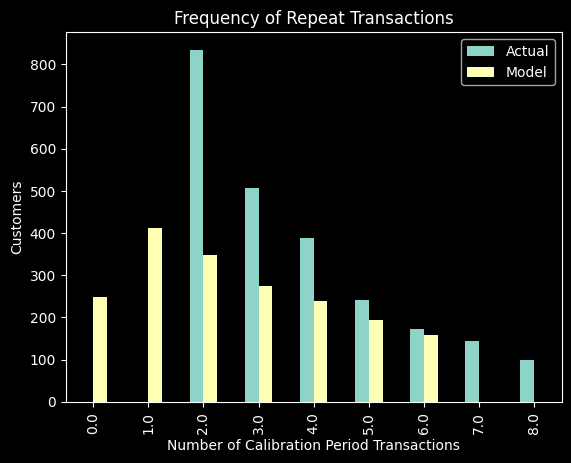

In [394]:
plot_period_transactions(bgf)

In [395]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"],cltv_df["monetary"])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [396]:
ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary"]).sort_values(ascending = False)

Customer ID
12415.00000   5772.17817
12590.00000   5029.41962
12435.00000   4288.94402
12409.00000   3918.81281
14088.00000   3917.12972
                 ...    
17988.00000     29.58471
15516.00000     23.40699
18037.00000     12.65760
17816.00000     10.52906
16454.00000      5.81948
Length: 2845, dtype: float64

In [397]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary"])

In [398]:
cltv_df.sort_values(by="expected_average_profit",ascending=False)

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_average_profit
Customer ID,,,,,,,
12415.00000,44.71429,48.28571,21,5724.30262,0.39071,1.56033,5772.17817
12590.00000,0.00000,30.28571,2,4591.17250,0.01247,0.04972,5029.41962
12435.00000,26.85714,38.28571,2,3914.94500,0.07368,0.29392,4288.94402
12409.00000,14.71429,26.14286,3,3690.89000,0.12021,0.47927,3918.81281
14088.00000,44.57143,46.14286,13,3864.55462,0.26466,1.05682,3917.12972
...,...,...,...,...,...,...,...
17988.00000,44.85714,46.71429,7,28.31857,0.15499,0.61883,29.58471
15516.00000,0.14286,6.71429,3,20.81000,0.24100,0.95753,23.40699
18037.00000,29.57143,51.85714,6,11.67000,0.09575,0.38235,12.65760


In [404]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary"],
                                   time=3, #monthly
                                   freq="W",#freq of T
                                   discount_rate=0.01)

In [405]:
cltv

Customer ID
12347.00000   1128.63234
12348.00000    536.98511
12352.00000    528.18835
12356.00000   1053.56645
12358.00000    947.10185
                 ...    
18272.00000   1157.04976
18273.00000     94.48486
18282.00000    166.78952
18283.00000    517.38013
18287.00000    986.86009
Name: clv, Length: 2845, dtype: float64

In [401]:
cltv_final = pd.merge(cltv_df,cltv,right_index=True,left_index=True)
cltv_final

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_average_profit,clv
Customer ID,,,,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14065,0.56167,631.91230,1128.63234
12348.00000,40.28571,51.28571,4,442.69500,0.09125,0.36432,463.74596,536.98511
12352.00000,37.14286,42.42857,8,219.54250,0.18514,0.73914,224.88677,528.18835
12356.00000,43.14286,46.57143,3,937.14333,0.08344,0.33304,995.99892,1053.56645
12358.00000,21.28571,21.57143,2,575.21000,0.11899,0.47404,631.90217,947.10185
...,...,...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17265,0.68898,529.01845,1157.04976
18273.00000,36.42857,36.85714,3,68.00000,0.10156,0.40519,73.49423,94.48486
18282.00000,16.85714,18.14286,2,89.02500,0.13324,0.53057,99.52493,166.78952


In [402]:
cltv_final.sort_values(by="clv",ascending=False)

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_average_profit,clv
Customer ID,,,,,,,,
14646.00000,50.42857,50.71429,73,3646.07568,1.24394,4.96845,3654.81481,57772.04824
18102.00000,52.28571,52.57143,60,3859.73908,0.99672,3.98116,3870.99693,49035.01241
14096.00000,13.85714,14.57143,17,3163.58824,0.78092,3.11195,3196.43606,31471.24721
12415.00000,44.71429,48.28571,21,5724.30262,0.39071,1.56033,5772.17817,28644.14802
14911.00000,53.14286,53.42857,201,691.71010,3.22852,12.89616,692.32637,28411.52886
...,...,...,...,...,...,...,...,...
17912.00000,7.71429,52.14286,5,62.20200,0.00156,0.00621,65.21106,1.28756
15332.00000,0.42857,52.85714,4,415.26500,0.00014,0.00057,435.07200,0.78673
16725.00000,9.85714,53.14286,7,111.57429,0.00053,0.00210,114.95683,0.76654


In [403]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"],4,labels=["D","C","B","A"])

In [407]:
cltv_final.groupby("segment").agg(["mean","sum"])

recency                    T             frequency        monetary  \
            mean         sum     mean         sum      mean   sum      mean   
segment                                                                       
D       22.55257 16057.42857 40.64266 28937.57143   3.02669  2155 182.88952   
C       30.40647 21619.00000 37.96363 26992.14286   4.04923  2879 273.24847   
B       29.51879 20987.85714 35.00864 24891.14286   5.52461  3928 376.64556   
A       31.19068 22176.57143 34.25658 24356.42857  11.36006  8077 656.17692   

                     expected_puch_1_week           expected_puch_1_month  \
                 sum                 mean       sum                  mean   
segment                                                                     
D       130217.33954              0.07236  51.52145               0.28861   
C       194279.66329              0.12005  85.35405               0.47880   
B       267794.99363              0.16564 117.76959               0.66038   
A       466541.78973              0.28303 201.23477               1.12874   

                  expected_average_profit                     clv  \
              sum                    mean          sum       mean   
segment                                                             
D       205.48871               198.46827 141309.40702  147.99249   
C       340.42346               291.65256 207364.96902  384.35183   
B       469.53354               397.19980 282409.05535  702.33198   
A       802.53394               681.89824 484829.64685 2299.73431   

                       
                  sum  
segment                
D        105370.65121  
C        273274.15426  
B        499358.04005  
A       1635111.09410

In [409]:
df = df_.copy()
def create_cltv(df,month=3):
    #data prep
    df.dropna(inplace=True)
    df = df[~df["Invoice"].str.contains("C",na=False)]
    df = df[df["Quantity"]>0]
    df = df[df["Price"]>0]
    def find_limits(df,variable):
        q1 = df[variable].quantile(0.01)
        q3 = df[variable].quantile(0.99)
        iqr = q3 - q1
        upper_limit = q3 + 1.5*iqr
        lower_limit = q1 - 1.5*iqr
        df[variable].clip(upper=upper_limit,inplace=True)
    
    find_limits(df,"Quantity")
    find_limits(df,"Price")
    df["total_price"] = df["Quantity"] * df["Price"]
    today_date= dt.datetime(2011,12,11)
    cltv_df = df.groupby("Customer ID").agg({"InvoiceDate":[lambda date: (date.max() - date.min()).days,
                                                        lambda date: (today_date - date.min()).days],
                                         "Invoice":lambda x:x.nunique(),
                                         "total_price":lambda x:x.sum()})
    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ["recency","T","frequency","monetary"]
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[cltv_df["frequency"]>1]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7
    
    # BG-NBD model
    bgf = BetaGeoFitter(penalizer_coef=0.01)
    bgf.fit(frequency=cltv_df["frequency"],
        recency=cltv_df["recency"],
        T=cltv_df["T"])
    cltv_df["expected_puch_1_week"] = bgf.predict(1,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])
    cltv_df["expected_puch_1_month"] =bgf.predict(4,
            cltv_df["frequency"],
            cltv_df["recency"],
            cltv_df["T"])
    
    # Gamma Gamma
    
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df["frequency"],cltv_df["monetary"])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df["frequency"],
                                        cltv_df["monetary"])
    
    #final
    cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df["frequency"],
                                   cltv_df["recency"],
                                   cltv_df["T"],
                                   cltv_df["monetary"],
                                   time=month, #monthly
                                   freq="W",#freq of T
                                   discount_rate=0.01)
    cltv_final = pd.merge(cltv_df,cltv,right_index=True,left_index=True)
    cltv_final["segment"] = pd.qcut(cltv_final["clv"],4,labels=["D","C","B","A"])
    return cltv_final
create_cltv(df)

,recency,T,frequency,monetary,expected_puch_1_week,expected_puch_1_month,expected_average_profit,clv,segment
Customer ID,,,,,,,,,
12347.00000,52.14286,52.57143,7,615.71429,0.14065,0.56167,631.91230,1128.63234,A
12348.00000,40.28571,51.28571,4,442.69500,0.09125,0.36432,463.74596,536.98511,B
12352.00000,37.14286,42.42857,8,219.54250,0.18514,0.73914,224.88677,528.18835,B
12356.00000,43.14286,46.57143,3,937.14333,0.08344,0.33304,995.99892,1053.56645,A
12358.00000,21.28571,21.57143,2,575.21000,0.11899,0.47404,631.90217,947.10185,A
...,...,...,...,...,...,...,...,...,...
18272.00000,34.85714,35.28571,6,513.09667,0.17265,0.68898,529.01845,1157.04976,A
18273.00000,36.42857,36.85714,3,68.00000,0.10156,0.40519,73.49423,94.48486,D
18282.00000,16.85714,18.14286,2,89.02500,0.13324,0.53057,99.52493,166.78952,D
